# Cluster Modeling 

In [67]:
import warnings
warnings.filterwarnings(action='ignore')

import pandas as pd 
import numpy as np
pd.set_option("max_rows", 500)
pd.set_option("max_columns", 500)
pd.set_option('float_format', '{:f}'.format)

import dataload

import os 
import random
import datetime
from tqdm import tqdm 
from functools import reduce

%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt 

plt.style.use('seaborn')
plt.rc('font', family='AppleGothic')
plt.rc('axes', unicode_minus=False)

In [177]:
from sklearn.preprocessing import StandardScaler

In [2]:
beauty = pd.read_csv('beauty_tsclustering_0606.csv', encoding='cp949')
weather = pd.read_csv('weather_final.csv', encoding='cp949')
weatherindex = pd.read_csv('data_with_weather.csv', encoding='cp949')
search = pd.read_csv('trend_with_weather.csv', encoding='cp949')

beauty.shape, weather.shape, weatherindex.shape, search.shape

((131, 367), (11680, 27), (2056899, 18), (2568668, 12))

## 1. Data Merge 

In [39]:
weather2 = weather.drop_duplicates('날짜', keep='first').reset_index(drop=True).rename(columns={'날짜' : 'date'})

In [17]:
weatherindex2 = weatherindex[['date', 'avg_ta', 'max_ta', 'min_ta', 'rn_day', 'rn_hr1', 'avg_ws', 'PM10', 'PM25', 'hm_max', 'sum_ss_hr', 'max_pa']]
weatherindex2 = weatherindex2.drop_duplicates('date', keep='first').reset_index(drop=True)

print(weatherindex2.shape)
weatherindex2.head()

(730, 12)


,date,avg_ta,max_ta,min_ta,rn_day,rn_hr1,avg_ws,PM10,PM25,hm_max,sum_ss_hr,max_pa
0,2018-01-01,0.885198,5.464146,-2.880740,0.000000,0.000000,2.157094,44.015611,21.477208,61.923313,52.276365,1020.592385
1,2018-01-02,1.208896,6.014385,-3.135167,0.000000,0.000000,1.903604,59.179487,33.836826,74.169781,37.996677,1021.524802
2,2018-01-03,-0.798604,3.236083,-3.619615,0.000000,0.000000,2.623562,32.757902,18.242391,59.310396,53.216885,1023.277500
3,2018-01-04,-1.075625,2.345708,-4.636646,0.000000,0.000000,1.842729,38.685406,23.045234,63.961750,33.707167,1021.539615
4,2018-01-05,0.584646,5.053948,-2.273062,0.316688,0.087646,2.280937,46.151746,30.785155,71.747365,40.403240,1014.525396


In [10]:
search.head()

,date,sex,age,big_cat,sm_cat,qty,ratio,오늘날씨,미세먼지,오늘 비,기상정보,태풍정보
0,2018-01-01,F,20,식품,가공란,37.000000,0.000000,10.693870,4.091370,0.000000,0.000000,0.044400
1,2018-01-01,F,30,식품,가공란,16.000000,0.000000,12.429690,6.352940,0.000000,0.512820,0.424170
2,2018-01-01,F,40,식품,가공란,9.000000,0.000000,13.022490,4.880370,0.000000,0.406500,0.000000
3,2018-01-01,F,50,식품,가공란,3.000000,0.000000,11.690800,4.533500,1.219510,0.909090,0.000000
4,2018-01-01,M,20,식품,가공란,13.000000,0.000000,11.230320,3.612960,0.389100,2.222220,0.040600


In [23]:
final = search.merge(weatherindex[['date','sex','age','big_cat','sm_cat','qty','cnt']], on = ['date','sex','age','big_cat','sm_cat','qty'], how='left')

In [24]:
final['cnt'] = final['cnt'].fillna(0)

In [26]:
final = final.merge(weatherindex2, on='date', how='left')

In [29]:
final = final[['date', 'sex', 'age', 'big_cat', 'sm_cat', 'qty', 'cnt', 'ratio', '오늘날씨',
               '미세먼지', '오늘 비', '기상정보', '태풍정보', 'avg_ta', 'max_ta', 'min_ta',
               'rn_day', 'rn_hr1', 'avg_ws', 'PM10', 'PM25', 'hm_max', 'sum_ss_hr',
               'max_pa']]

In [43]:
final = final.merge(weather2[['date', '분기', '요일', '공휴일명', '공휴일여부', '주말여부', '계절']], on='date', how='left')

In [47]:
print(final.shape)
final.head()

(2568668, 30)


,date,sex,age,big_cat,sm_cat,qty,cnt,ratio,오늘날씨,미세먼지,오늘 비,기상정보,태풍정보,avg_ta,max_ta,min_ta,rn_day,rn_hr1,avg_ws,PM10,PM25,hm_max,sum_ss_hr,max_pa,분기,요일,공휴일명,공휴일여부,주말여부,계절
0,2018-01-01,F,20,식품,가공란,37.000000,0.480964,0.000000,10.693870,4.091370,0.000000,0.000000,0.044400,0.885198,5.464146,-2.880740,0.000000,0.000000,2.157094,44.015611,21.477208,61.923313,52.276365,1020.592385,1,0,1월1일,1,0,3
1,2018-01-01,F,30,식품,가공란,16.000000,0.480964,0.000000,12.429690,6.352940,0.000000,0.512820,0.424170,0.885198,5.464146,-2.880740,0.000000,0.000000,2.157094,44.015611,21.477208,61.923313,52.276365,1020.592385,1,0,1월1일,1,0,3
2,2018-01-01,F,40,식품,가공란,9.000000,0.480964,0.000000,13.022490,4.880370,0.000000,0.406500,0.000000,0.885198,5.464146,-2.880740,0.000000,0.000000,2.157094,44.015611,21.477208,61.923313,52.276365,1020.592385,1,0,1월1일,1,0,3
3,2018-01-01,F,50,식품,가공란,3.000000,0.480964,0.000000,11.690800,4.533500,1.219510,0.909090,0.000000,0.885198,5.464146,-2.880740,0.000000,0.000000,2.157094,44.015611,21.477208,61.923313,52.276365,1020.592385,1,0,1월1일,1,0,3
4,2018-01-01,M,20,식품,가공란,13.000000,0.480964,0.000000,11.230320,3.612960,0.389100,2.222220,0.040600,0.885198,5.464146,-2.880740,0.000000,0.000000,2.157094,44.015611,21.477208,61.923313,52.276365,1020.592385,1,0,1월1일,1,0,3


In [45]:
final.to_csv("final_0606.csv", encoding='cp949')

In [59]:
a = pd.read_csv("final_0606.csv", encoding='cp949')

## 2. Cluster DataFrame 

In [124]:
beauty_final = final[final["big_cat"]=='뷰티'].reset_index(drop=True)

print(beauty_final.shape)
beauty_final.head()

(840541, 30)


,date,sex,age,big_cat,sm_cat,qty,cnt,ratio,오늘날씨,미세먼지,오늘 비,기상정보,태풍정보,avg_ta,max_ta,min_ta,rn_day,rn_hr1,avg_ws,PM10,PM25,hm_max,sum_ss_hr,max_pa,분기,요일,공휴일명,공휴일여부,주말여부,계절
0,2018-01-01,F,20,뷰티,기능성 링클케어 화장품,2.000000,12.154295,25.000000,10.693870,4.091370,0.000000,0.000000,0.044400,0.885198,5.464146,-2.880740,0.000000,0.000000,2.157094,44.015611,21.477208,61.923313,52.276365,1020.592385,1,0,1월1일,1,0,3
1,2018-01-01,F,30,뷰티,기능성 링클케어 화장품,0.000000,0.000000,41.666660,12.429690,6.352940,0.000000,0.512820,0.424170,0.885198,5.464146,-2.880740,0.000000,0.000000,2.157094,44.015611,21.477208,61.923313,52.276365,1020.592385,1,0,1월1일,1,0,3
2,2018-01-01,F,40,뷰티,기능성 링클케어 화장품,1.000000,12.154295,6.250000,13.022490,4.880370,0.000000,0.406500,0.000000,0.885198,5.464146,-2.880740,0.000000,0.000000,2.157094,44.015611,21.477208,61.923313,52.276365,1020.592385,1,0,1월1일,1,0,3
3,2018-01-01,F,50,뷰티,기능성 링클케어 화장품,0.000000,0.000000,11.111110,11.690800,4.533500,1.219510,0.909090,0.000000,0.885198,5.464146,-2.880740,0.000000,0.000000,2.157094,44.015611,21.477208,61.923313,52.276365,1020.592385,1,0,1월1일,1,0,3
4,2018-01-01,M,20,뷰티,기능성 링클케어 화장품,0.000000,0.000000,28.571420,11.230320,3.612960,0.389100,2.222220,0.040600,0.885198,5.464146,-2.880740,0.000000,0.000000,2.157094,44.015611,21.477208,61.923313,52.276365,1020.592385,1,0,1월1일,1,0,3


In [125]:
beauty_final = beauty_final.drop(['big_cat', '공휴일명'], axis=1)
beauty_final["sex"] = beauty_final["sex"].apply(lambda x : 1 if x=='F' else 0)

In [128]:
beauty_final = pd.get_dummies(beauty_final, columns=['age'], prefix='age', drop_first=True) 

In [130]:
cluster0 = beauty[beauty["cluster"] == 0] 
cluster1 = beauty[beauty["cluster"] == 1]
cluster2 = beauty[beauty["cluster"] == 2]

In [131]:
cluster0 = list(cluster0['sm_cat']) 
cluster1 = list(cluster1['sm_cat']) 
cluster2 = list(cluster2['sm_cat']) 

In [132]:
tqdm.pandas()
beauty_final['date'] = beauty_final["date"].progress_apply(lambda x : pd.to_datetime(str(x), format='%Y-%m-%d'))

100%|██████████| 840541/840541 [01:00<00:00, 13874.81it/s]


In [154]:
bty_c0 = beauty_final[beauty_final['sm_cat'].isin(cluster0)].reset_index(drop=True)
bty_c1 = beauty_final[beauty_final['sm_cat'].isin(cluster1)].reset_index(drop=True)
bty_c2 = beauty_final[beauty_final['sm_cat'].isin(cluster2)].reset_index(drop=True)

bty_c0.shape, bty_c1.shape, bty_c2.shape 

((388677, 31), (191380, 31), (260484, 31))

## 3. 지역 선정해 붙이기 

* Cluster0 : 겨울 - 서울 + 천안, 광주 
* Cluster1 : 스테디셀러 - 서울 + 부산, 제주 
* Cluster2 : 여름 - 서울 + 대구, 강릉 

In [116]:
weather = pd.read_csv('weather_final.csv', encoding='cp949')

In [115]:
def region_weather(지역):
    weather_true = weather.drop(['연', '월', '일', '분기', '요일', '공휴일명', '공휴일여부', '주말여부', '계절'], axis=1) # weather_final
    weather1 = pd.pivot_table(weather_true[weather_true['지역'].isin(지역)], index='날짜', columns='지역').reset_index(drop=True)
    weather1.columns = [l+"_"+w for l,w in zip(weather1.columns.get_level_values(1), weather1.columns.get_level_values(0))]
    weather1['날짜'] = weather['날짜'].unique()
    weather1['날짜'] = weather1["날짜"].progress_apply(lambda x : pd.to_datetime(str(x), format='%Y-%m-%d'))
    weather1['연'] = weather1['날짜'].apply(lambda x : x.year)
    weather1['월'] = weather1['날짜'].apply(lambda x : x.month)
    return weather1.rename(columns = {'날짜' : 'date'})

In [ ]:
def get_dummies(data, var_list):
    # var_list = ['var1', 'var2']
    for var in var_list:
        if var=='sex':
            data[var] = pd.get_dummies(data[var]).iloc[:,:1] # F(1), M(0)
        else:
            data = pd.concat([data.drop(var, axis=1), pd.get_dummies(data[var], prefix=var, drop_first=True)], axis=1)
    return data

In [155]:
weather0 = region_weather(['서울','천안','광주'])
weather1 = region_weather(['서울','부산','제주'])
weather2 = region_weather(['서울','부산','제주'])

weather0.shape, weather1.shape, weather2.shape

100%|██████████| 730/730 [00:00<00:00, 13204.31it/s]


((730, 51), (730, 51), (730, 51))

In [156]:
bty_c0 = bty_c0.merge(weather0, on='date', how='left')
bty_c1 = bty_c1.merge(weather1, on='date', how='left')
bty_c2 = bty_c2.merge(weather2, on='date', how='left')

bty_c0.shape, bty_c1.shape, bty_c2.shape 

((388677, 81), (191380, 81), (260484, 81))

In [157]:
bty_c0.head()

,date,sex,sm_cat,qty,cnt,ratio,오늘날씨,미세먼지,오늘 비,기상정보,태풍정보,avg_ta,max_ta,min_ta,rn_day,rn_hr1,avg_ws,PM10,PM25,hm_max,sum_ss_hr,max_pa,분기,요일,공휴일여부,주말여부,계절,age_30,age_40,age_50,age_60,광주_1시간최대강수량,서울_1시간최대강수량,천안_1시간최대강수량,광주_1시간최대습도,서울_1시간최대습도,천안_1시간최대습도,광주_PM10,서울_PM10,천안_PM10,광주_PM25,서울_PM25,천안_PM25,광주_강수여부,서울_강수여부,천안_강수여부,광주_열지수,서울_열지수,천안_열지수,광주_일별강수량,서울_일별강수량,천안_일별강수량,광주_일조시간합,서울_일조시간합,천안_일조시간합,광주_지점번호,서울_지점번호,천안_지점번호,광주_체감온도,서울_체감온도,천안_체감온도,광주_최고기온,서울_최고기온,천안_최고기온,광주_최고현지기압,서울_최고현지기압,천안_최고현지기압,광주_최저기온,서울_최저기온,천안_최저기온,광주_평균기온,서울_평균기온,천안_평균기온,광주_평균풍속,서울_평균풍속,천안_평균풍속,광주_폭염여부,서울_폭염여부,천안_폭염여부,연,월
0,2018-01-01,1,기능성 아이케어 화장품,57.000000,0.895782,17.948710,10.693870,4.091370,0.000000,0.000000,0.044400,0.885198,5.464146,-2.880740,0.000000,0.000000,2.157094,44.015611,21.477208,61.923313,52.276365,1020.592385,1,0,1,0,3,0,0,0,0,0.000000,0.000000,0.000000,65.900000,57.100000,88.800000,50.770833,42.307692,51.750000,20.508333,21.470696,26.444444,0,0,0,-37.638234,-44.993999,-48.073016,0.000000,0.000000,0.000000,55.500000,51.600000,50.500000,156,108,232,11.872189,9.649709,9.582651,7.100000,3.800000,3.800000,1020.900000,1018.100000,1019.100000,-1.000000,-5.100000,-8.500000,2.300000,-1.300000,-2.800000,1.600000,1.400000,0.900000,0,0,0,2018,1
1,2018-01-01,1,기능성 아이케어 화장품,83.000000,0.895782,32.352940,12.429690,6.352940,0.000000,0.512820,0.424170,0.885198,5.464146,-2.880740,0.000000,0.000000,2.157094,44.015611,21.477208,61.923313,52.276365,1020.592385,1,0,1,0,3,1,0,0,0,0.000000,0.000000,0.000000,65.900000,57.100000,88.800000,50.770833,42.307692,51.750000,20.508333,21.470696,26.444444,0,0,0,-37.638234,-44.993999,-48.073016,0.000000,0.000000,0.000000,55.500000,51.600000,50.500000,156,108,232,11.872189,9.649709,9.582651,7.100000,3.800000,3.800000,1020.900000,1018.100000,1019.100000,-1.000000,-5.100000,-8.500000,2.300000,-1.300000,-2.800000,1.600000,1.400000,0.900000,0,0,0,2018,1
2,2018-01-01,1,기능성 아이케어 화장품,81.000000,0.895782,20.833330,13.022490,4.880370,0.000000,0.406500,0.000000,0.885198,5.464146,-2.880740,0.000000,0.000000,2.157094,44.015611,21.477208,61.923313,52.276365,1020.592385,1,0,1,0,3,0,1,0,0,0.000000,0.000000,0.000000,65.900000,57.100000,88.800000,50.770833,42.307692,51.750000,20.508333,21.470696,26.444444,0,0,0,-37.638234,-44.993999,-48.073016,0.000000,0.000000,0.000000,55.500000,51.600000,50.500000,156,108,232,11.872189,9.649709,9.582651,7.100000,3.800000,3.800000,1020.900000,1018.100000,1019.100000,-1.000000,-5.100000,-8.500000,2.300000,-1.300000,-2.800000,1.600000,1.400000,0.900000,0,0,0,2018,1
3,2018-01-01,1,기능성 아이케어 화장품,33.000000,0.895782,8.333330,11.690800,4.533500,1.219510,0.909090,0.000000,0.885198,5.464146,-2.880740,0.000000,0.000000,2.157094,44.015611,21.477208,61.923313,52.276365,1020.592385,1,0,1,0,3,0,0,1,0,0.000000,0.000000,0.000000,65.900000,57.100000,88.800000,50.770833,42.307692,51.750000,20.508333,21.470696,26.444444,0,0,0,-37.638234,-44.993999,-48.073016,0.000000,0.000000,0.000000,55.500000,51.600000,50.500000,156,108,232,11.872189,9.649709,9.582651,7.100000,3.800000,3.800000,1020.900000,1018.100000,1019.100000,-1.000000,-5.100000,-8.500000,2.300000,-1.300000,-2.800000,1.600000,1.400000,0.900000,0,0,0,2018,1
4,2018-01-01,1,기능성 아이케어 화장품,2.000000,0.895782,14.285710,13.927120,5.478870,0.000000,0.000000,0.000000,0.885198,5.464146,-2.880740,0.000000,0.000000,2.157094,44.015611,21.477208,61.923313,52.276365,1020.592385,1,0,1,0,3,0,0,0,1,0.000000,0.000000,0.000000,65.900000,57.100000,88.800000,50.770833,42.307692,51.750000,20.508333,21.470696,26.444444,0,0,0,-37.638234,-44.993999,-48.073016,0.000000,0.000000,0.000000,55.500000,51.600000,50.500000,156,108,232,11.872189,9.649709,9.582651,7.100000,3.800000,3.800000,1020.900000,1018.100000,1019.100000,-1.000000,-5.100000,-8.500000,2.300000,-1.300000,-2.800000,1.600000,1.400000,0.900000,0,0,0,2018,1


In [160]:
bty_c0_2 = pd.get_dummies(bty_c0, columns=['sm_cat'], drop_first = True)
bty_c1_2 = pd.get_dummies(bty_c1, columns=['sm_cat'], drop_first = True)
bty_c2_2 = pd.get_dummies(bty_c2, columns=['sm_cat'], drop_first = True)

bty_c0_2.shape, bty_c1_2.shape, bty_c2_2.shape 

((388677, 137), (191380, 111), (260484, 120))

In [161]:
bty_c0_2.head()

,date,sex,qty,cnt,ratio,오늘날씨,미세먼지,오늘 비,기상정보,태풍정보,avg_ta,max_ta,min_ta,rn_day,rn_hr1,avg_ws,PM10,PM25,hm_max,sum_ss_hr,max_pa,분기,요일,공휴일여부,주말여부,계절,age_30,age_40,age_50,age_60,광주_1시간최대강수량,서울_1시간최대강수량,천안_1시간최대강수량,광주_1시간최대습도,서울_1시간최대습도,천안_1시간최대습도,광주_PM10,서울_PM10,천안_PM10,광주_PM25,서울_PM25,천안_PM25,광주_강수여부,서울_강수여부,천안_강수여부,광주_열지수,서울_열지수,천안_열지수,광주_일별강수량,서울_일별강수량,천안_일별강수량,광주_일조시간합,서울_일조시간합,천안_일조시간합,광주_지점번호,서울_지점번호,천안_지점번호,광주_체감온도,서울_체감온도,천안_체감온도,광주_최고기온,서울_최고기온,천안_최고기온,광주_최고현지기압,서울_최고현지기압,천안_최고현지기압,광주_최저기온,서울_최저기온,천안_최저기온,광주_평균기온,서울_평균기온,천안_평균기온,광주_평균풍속,서울_평균풍속,천안_평균풍속,광주_폭염여부,서울_폭염여부,천안_폭염여부,연,월,sm_cat_기능성 영양보습 화장품,sm_cat_기능성 트러블케어 화장품,sm_cat_기초 화장용 로션,sm_cat_기초 화장용 미스트,sm_cat_기초 화장용 스킨,sm_cat_기초 화장용 에센스,sm_cat_기초 화장용 오일/앰플,sm_cat_기초 화장용 크림,sm_cat_남성 로션,sm_cat_남성 메이크업,sm_cat_남성 세트,sm_cat_남성 쉐이빙,sm_cat_남성 스킨,sm_cat_남성 에센스,sm_cat_남성 크림,sm_cat_네일케어,sm_cat_린스,sm_cat_립앤아이 리무버,sm_cat_메이크업 브러쉬,sm_cat_바디 보습제,sm_cat_바디 세트,sm_cat_바디 스크럽,sm_cat_바디케어용 때비누,sm_cat_베이스 메이크업용 BB크림,sm_cat_베이스 메이크업용 가루파우더,sm_cat_뷰티 속눈썹/쌍꺼풀,sm_cat_뷰티 화장솜,sm_cat_뷰티 화장품 공병/케이스,sm_cat_뷰티용 샤프너,sm_cat_색조 메이크업 립글로스,sm_cat_색조 메이크업 립라이너,sm_cat_색조 메이크업 립밤,sm_cat_색조 메이크업 립스틱,sm_cat_색조 메이크업 립틴트,sm_cat_색조 메이크업 마스카라,sm_cat_색조 메이크업 아이섀도우,sm_cat_샴푸,sm_cat_세안도구,sm_cat_손톱정리도구,sm_cat_스크럽/필링크림,sm_cat_스킨케어 곡물팩,sm_cat_입욕제,sm_cat_클렌징 오일,sm_cat_클렌징 워터/젤,sm_cat_트리트먼트,sm_cat_풋크림,sm_cat_핸드크림,sm_cat_향수세트,sm_cat_헤어 브러쉬,sm_cat_헤어무스,sm_cat_헤어스타일링용 염색약,sm_cat_헤어스타일링용 펌제,sm_cat_헤어스타일링용 흑채,sm_cat_헤어스프레이,sm_cat_헤어에센스,sm_cat_헤어젤,sm_cat_화장 퍼프
0,2018-01-01,1,57.000000,0.895782,17.948710,10.693870,4.091370,0.000000,0.000000,0.044400,0.885198,5.464146,-2.880740,0.000000,0.000000,2.157094,44.015611,21.477208,61.923313,52.276365,1020.592385,1,0,1,0,3,0,0,0,0,0.000000,0.000000,0.000000,65.900000,57.100000,88.800000,50.770833,42.307692,51.750000,20.508333,21.470696,26.444444,0,0,0,-37.638234,-44.993999,-48.073016,0.000000,0.000000,0.000000,55.500000,51.600000,50.500000,156,108,232,11.872189,9.649709,9.582651,7.100000,3.800000,3.800000,1020.900000,1018.100000,1019.100000,-1.000000,-5.100000,-8.500000,2.300000,-1.300000,-2.800000,1.600000,1.400000,0.900000,0,0,0,2018,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2018-01-01,1,83.000000,0.895782,32.352940,12.429690,6.352940,0.000000,0.512820,0.424170,0.885198,5.464146,-2.880740,0.000000,0.000000,2.157094,44.015611,21.477208,61.923313,52.276365,1020.592385,1,0,1,0,3,1,0,0,0,0.000000,0.000000,0.000000,65.900000,57.100000,88.800000,50.770833,42.307692,51.750000,20.508333,21.470696,26.444444,0,0,0,-37.638234,-44.993999,-48.073016,0.000000,0.000000,0.000000,55.500000,51.600000,50.500000,156,108,232,11.872189,9.649709,9.582651,7.100000,3.800000,3.800000,1020.900000,1018.100000,1019.100000,-1.000000,-5.100000,-8.500000,2.300000,-1.300000,-2.800000,1.600000,1.400000,0.900000,0,0,0,2018,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2018-01-01,1,81.000000,0.895782,20.833330,13.022490,4.880370,0.000000,0.406500,0.000000,0.885198,5.464146,-2.880740,0.000000,0.000000,2.157094,44.015611,21.477208,61.923313,52.276365,1020.592385,1,0,1,0,3,0,1,0,0,0.000000,0.000000,0.000000,65.900000,57.100000,88.800000,50.770833,42.307692,51.750000,20.508333,21.470696,26.444444,0,0,0,-37.638234,-44.993999,-48.073016,0.000000,0.000000,0.000000,55.500000,51.600000,50.500000,156,108,232,11.872189,9.649709,9.582651,7.100000,3.800000,3.800000,1020.900000,1018.100000,1019.100000,-1.000000,-5.100000,-8.500000,2.300000,-1.300000,-2.800000,1.600000,1.400000,0.900000,0,0,0,2018,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,2018-01-01,1,33.000000,0.895782,8.333330,11.690800,4.533500,1.219510,0.909090,0.000000,0.885198,5.464146,-2.880740,0.000000,0.000000,2.157094,44.015611,21.477208,61.923313,52.276365,1020.592385,1,0,1,0,3,0,0,1,0,0.000000,0.000000,0.000000,65.900000,57.100000,88.800000,50.770833,42

## 4. Train/Test Sampling 

In [165]:
def sampling(data):
    # 랜덤으로 요일 선택
    np.random.seed(1234)
    sample_day = []; sample_idx = []
    count = 730//7 
    day_list = day_list = [1,2,3,4,5,6,7]
    sample_list = [random.choice(day_list) for i in range(count)]

    # 랜덤으로 선택된 요일의 날짜
    start = datetime.datetime(2018, 1, 1)
    for days in sample_list:
        sample_day.append(start + datetime.timedelta(days = days))
        start = start + datetime.timedelta(weeks = 1)

    # 샘플링
    for date in sample_day:
        sample_idx.extend(data[data['date']==date].index)
        
    all_idx = data.index.tolist()
    train_idx = list(set(all_idx) - set(sample_idx))
    return data.iloc[train_idx].reset_index(drop=True), data.iloc[sample_idx].reset_index(drop=True)

In [170]:
train_0, test_0 = sampling(bty_c0_2)
train_1, test_1 = sampling(bty_c1_2)
train_2, test_2 = sampling(bty_c2_2)

In [171]:
print(train_0.shape, test_0.shape)
print(train_1.shape, test_1.shape)
print(train_2.shape, test_2.shape)

(333325, 137) (55352, 137)
(164208, 111) (27172, 111)
(223336, 120) (37148, 120)


In [173]:
train_0 = train_0.drop('date', axis=1) ; test_0 = test_0.drop('date', axis=1)
train_1 = train_1.drop('date', axis=1) ; test_1 = test_1.drop('date', axis=1)
train_2 = train_2.drop('date', axis=1) ; test_2 = test_2.drop('date', axis=1)

In [183]:
train_X0 , train_y0 = train_0.drop('qty', axis=1) , train_0.qty
test_X0 , test_y0 = test_0.drop('qty', axis=1) , test_0.qty

train_X1 , train_y1 = train_1.drop('qty', axis=1) , train_1.qty
test_X1 , test_y1 = test_1.drop('qty', axis=1) , test_1.qty

train_X2 , train_y2 = train_2.drop('qty', axis=1) , train_2.qty
test_X2 , test_y2 = test_2.drop('qty', axis=1) , test_2.qty

In [184]:
# standardization 
std_scaler = StandardScaler()

train_std_0 = std_scaler.fit_transform(train_X0) ; test_std_0 = std_scaler.transform(test_X0)
train_std_1 = std_scaler.fit_transform(train_X1) ; test_std_1 = std_scaler.transform(test_X1)
train_std_2 = std_scaler.fit_transform(train_X2) ; test_std_2 = std_scaler.transform(test_X2)

In [229]:
def standardize_1dim(y) : 
    return (y-y.mean())/y.std()

In [234]:
train_std_y0 = standardize_1dim(train_y0) ; test_std_y0 = standardize_1dim(test_y0)
train_std_y1 = standardize_1dim(train_y1) ; test_std_y1 = standardize_1dim(test_y1)
train_std_y2 = standardize_1dim(train_y2) ; test_std_y2 = standardize_1dim(test_y2)

In [247]:
train_X0.isnull().sum()

sex                          0
cnt                          0
ratio                        0
오늘날씨                         0
미세먼지                         0
오늘 비                         0
기상정보                         0
태풍정보                         0
avg_ta                       0
max_ta                       0
min_ta                       0
rn_day                       0
rn_hr1                       0
avg_ws                       0
PM10                         0
PM25                         0
hm_max                       0
sum_ss_hr                    0
max_pa                       0
분기                           0
요일                           0
공휴일여부                        0
주말여부                         0
계절                           0
age_30                       0
age_40                       0
age_50                       0
age_60                       0
광주_1시간최대강수량                  0
서울_1시간최대강수량                  0
천안_1시간최대강수량                  0
광주_1시간최대습도                   0
서울_1시간최대

## 5. Modeling

In [187]:
import xgboost as xgb
import lightgbm as lgb

In [188]:
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor 
from sklearn.ensemble import GradientBoostingRegressor

### Cluster 0 

In [245]:
# 1. XGBoost 
xgb_model1 = xgb.XGBRegressor(learning_rate=0.1, max_depth=5, n_estimators=100) 
xgb_model1.fit(train_X0, train_y0)
pred_y0 = xgb_model1.predict(test_X0)
print(mean_squared_error(test_y0, pred_y0))

476.5043429193484


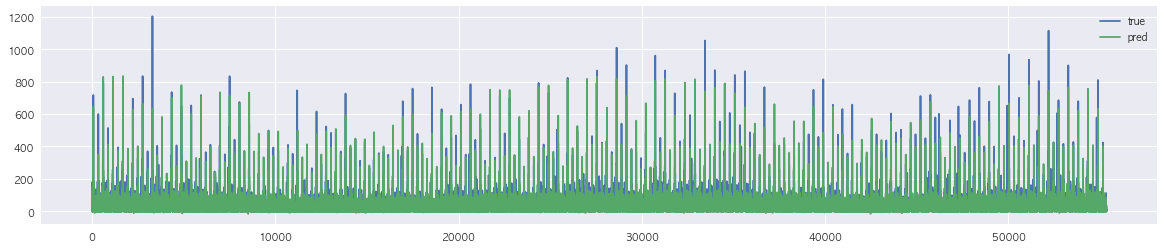

In [246]:
plt.figure(figsize=(20,4))
plt.plot(test_y0, label='true')
plt.plot(pred_y0, label='pred')
plt.legend(loc = 'best')
plt.show()

In [242]:
pd.DataFrame({'pred' : pred_y0, 'true' : test_y0})

,pred,true
0,-0.149742,52.000000
1,0.000890,179.000000
2,0.062032,154.000000
3,-0.291411,73.000000
4,-0.363020,8.000000
...,...,...
55347,-0.280772,4.000000
55348,-0.224120,13.000000
55349,-0.250531,10.000000
55350,-0.321315,4.000000


In [206]:
pd.DataFrame({
    'col' : train_X0.columns, 'feature importance' : xgb_model1.feature_importances_
}).sort_values('feature importance', ascending=False)[:30]

,col,feature importance
85,sm_cat_기초 화장용 크림,0.349795
114,sm_cat_샴푸,0.191795
83,sm_cat_기초 화장용 에센스,0.090042
26,age_50,0.030690
27,age_60,0.030272
0,sex,0.029462
82,sm_cat_기초 화장용 스킨,0.024402
24,age_30,0.022393
122,sm_cat_트리트먼트,0.018672
93,sm_cat_네일케어,0.015547


In [195]:
# 2. RandomForest
rf_model1 = RandomForestRegressor() 
rf_model1.fit(train_std_0, train_y0)
pred_y0 = rf_model1.predict(test_std_0)
print(mean_squared_error(test_y0, pred_y0))

ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

In [207]:
# 3. LightGBM 
lgb_model1 = lgb.LGBMRegressor() 
lgb_model1.fit(train_std_0, train_y0)
pred_y0 = lgb_model1.predict(test_std_0)
print(mean_squared_error(test_y0, pred_y0))

403.0858916179124


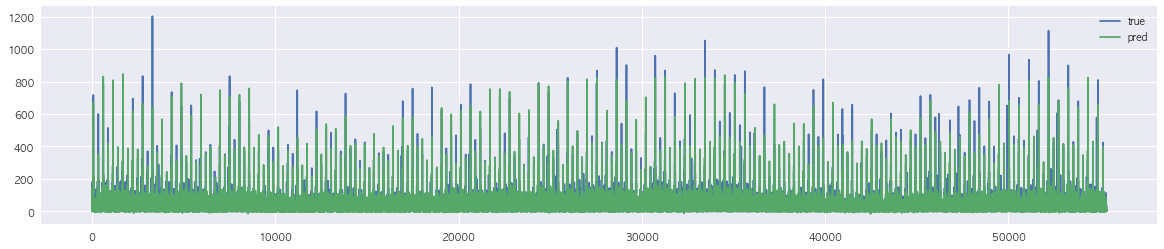

In [208]:
plt.figure(figsize=(20,4))
plt.plot(test_y0, label='true')
plt.plot(pred_y0, label='pred')
plt.legend(loc = 'best')
plt.show()

In [209]:
pd.DataFrame({'pred' : pred_y0, 'true' : test_y0})

,pred,true
0,25.661971,52.000000
1,43.311912,179.000000
2,64.578970,154.000000
3,10.860013,73.000000
4,2.856937,8.000000
...,...,...
55347,6.532013,4.000000
55348,8.975693,13.000000
55349,8.100592,10.000000
55350,4.937278,4.000000


### Cluster 1 

In [216]:
# 1. XGBoost 
xgb_model2 = xgb.XGBRegressor(learning_rate=0.1, max_depth=5, n_estimators=100) 
xgb_model2.fit(train_std_1, train_y1)
pred_y1 = xgb_model2.predict(test_std_1)
print(mean_squared_error(test_y1, pred_y1))

84.15505108725702


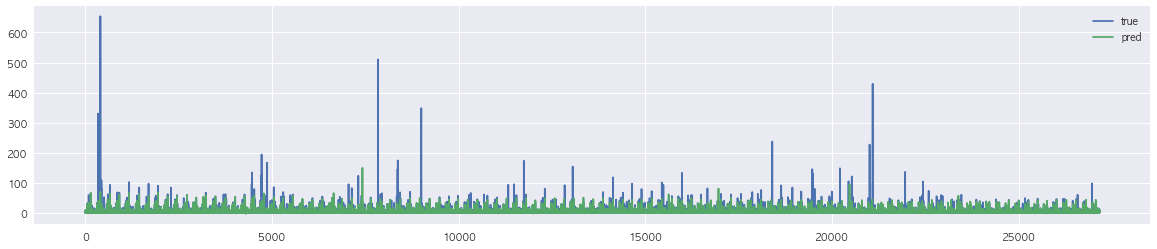

In [219]:
plt.figure(figsize=(20,4))
plt.plot(test_y1, label='true')
plt.plot(pred_y1, label='pred')
plt.legend(loc = 'best')
plt.show()

In [220]:
pd.DataFrame({'pred' : pred_y1, 'true' : test_y1})

,pred,true
0,0.665377,0.000000
1,7.521085,1.000000
2,7.016186,1.000000
3,0.248716,0.000000
4,-0.117363,0.000000
...,...,...
27167,3.519552,3.000000
27168,2.076360,1.000000
27169,2.579067,1.000000
27170,4.016119,1.000000


In [222]:
pd.DataFrame(test_y1).describe()

,qty
count,27172.000000
mean,4.436148
std,11.429471
min,0.000000
25%,0.000000
50%,2.000000
75%,5.000000
max,654.000000


In [ ]:
pd.DataFrame({
    'col' : train_X1.columns, 'feature importance' : xgb_model2.feature_importances_
}).sort_values('feature importance', ascending=False)[:30]

In [223]:
# 3. LightGBM 
lgb_model2 = lgb.LGBMRegressor() 
lgb_model2.fit(train_std_1, train_y1)
pred_y1 = lgb_model2.predict(test_std_1)
print(mean_squared_error(test_y1, pred_y1))

83.58638650513495


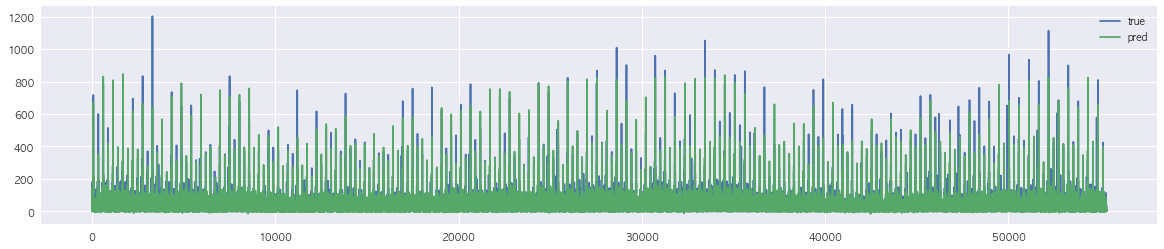

In [224]:
plt.figure(figsize=(20,4))
plt.plot(test_y0, label='true')
plt.plot(pred_y0, label='pred')
plt.legend(loc = 'best')
plt.show()

### Cluster2 

In [ ]:
# 1. XGBoost 
xgb_model3 = xgb.XGBRegressor(learning_rate=0.1, max_depth=16, n_estimators=1000) 
xgb_model3.fit(train_std_2, train_y2)

In [226]:
pred_y2 = xgb_model3.predict(test_std_2)
print(mean_squared_error(test_y2, pred_y2))

354.8776348178256


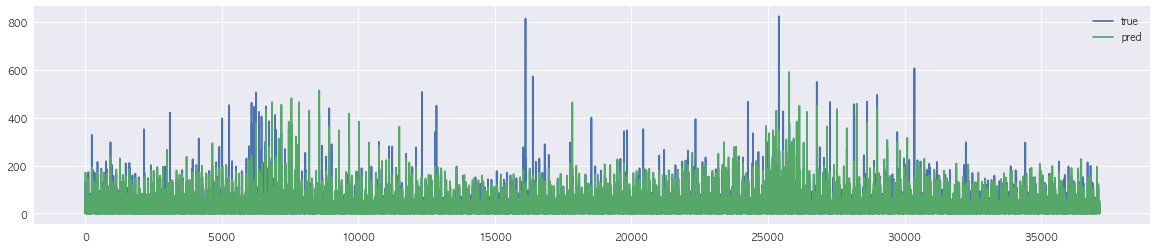

In [227]:
plt.figure(figsize=(20,4))
plt.plot(test_y2, label='true')
plt.plot(pred_y2, label='pred')
plt.legend(loc = 'best')
plt.show()

In [228]:
pd.DataFrame({
    'col' : train_X2.columns, 'feature importance' : xgb_model3.feature_importances_
}).sort_values('feature importance', ascending=False)[:30]

,col,feature importance
90,sm_cat_베이스 메이크업용 쿠션팩트,0.265215
107,sm_cat_스킨케어 마스크팩,0.108073
92,sm_cat_베이스 메이크업용 파운데이션,0.067511
87,sm_cat_바디 클렌져,0.066961
79,sm_cat_네일 메이크업 용품,0.058704
112,sm_cat_클렌징 폼,0.043076
27,age_60,0.032814
117,sm_cat_화장 비누,0.030562
91,sm_cat_베이스 메이크업용 파우더팩트,0.028958
105,sm_cat_선크림,0.026895
